## Index

1. [What is stim?](#what-is-stim)
2. [Install the `stim` python package.](#install-stim)
3. [Create a simple circuit, and sample from it.](#make-circuit)
4. [Add detector annotations to a circuit, and sample them.](#sample-detectors)
5. [Generate example error correction circuits.](#make-qec-circuits)
6. [Use `pymatching` to correct errors in a circuit.](#use-pymatching)
7. [Estimate the threshold of a repetition code using Monte Carlo sampling.](#rep-code)
8. [Use `sinter` to streamline the Monte Carlo sampling process.](#use-sinter)
9. [Estimate the threshold and footprint of a surface code.](#surface-code)
10. [Additional resources](additional-resources)

## Prereqs

This notebook assumes we can read and write Python code, and that we have a working Python 3.7+ environment (perhaps we are reading this notebook in such an environment).

This notebook assumes we understand what a quantum circuit is. For example, it assumes we know what a qubit is, what a Hadamard gate is, and what a CNOT gate is.

This notebook assumes we are a *little* familiar with stabilizer circuits. For example, it assumes we've heard that they can be simulated cheaply and that they can represent protocols such as quantum error correction.

This notebook assumes we are a *little* familiar with quantum error correcting codes. For example, it assumes we've heard the term "surface code" and "threshold".

<a class="anchor" id="what-is-stim"></a>
# 1. What is Stim?

Stim is an [open source tool](https://github.com/quantumlib/Stim) for high performance analysis and simulation of quantum stabilizer circuits, with a focus on quantum error correction circuits.

Here is a plot from the [paper introducing Stim](https://doi.org/10.22331/q-2021-07-06-497), showing that Stim is thousands of times faster than other tools at sampling stabilizer circuits:

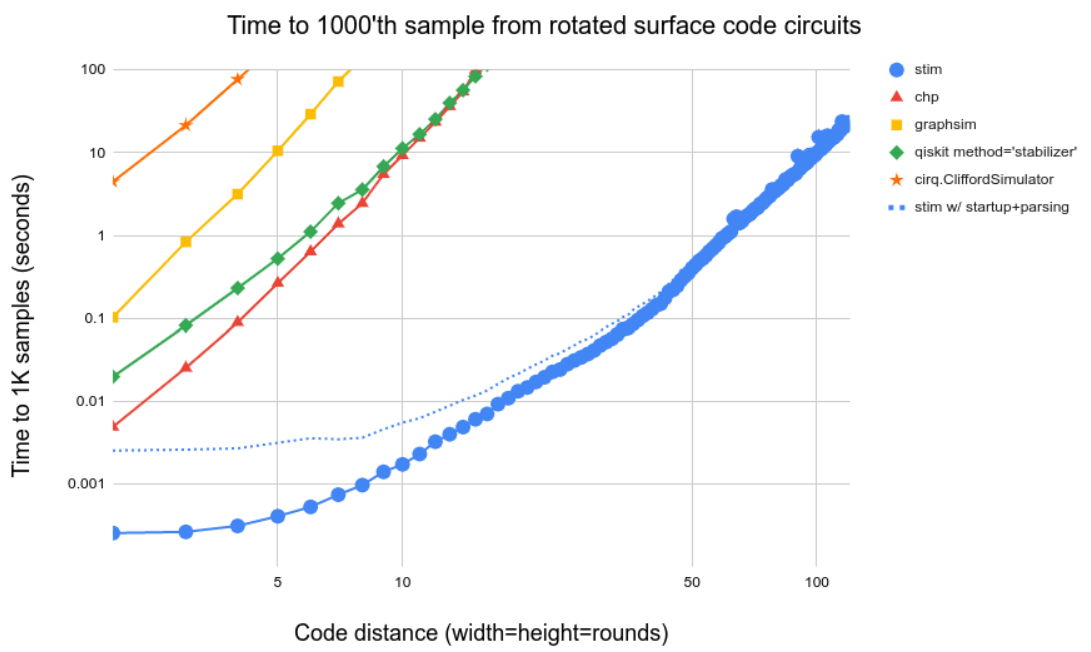

In addition to fast simulation, Stim provides general utilities for editing, inspecting, and transforming stabilizer circuits. In particular, Stim can automatically derive a matching graph from a stabilizer circuit annotated with detectors and noise channels.

<a class="anchor" id="install-stim"></a>
# 2. Install the Stim python package.

The first thing to do is to install and import stim.
Thanks to the python ecosystem, this is easy!
Stim is available as a pypi package, and can be installed using `pip install stim` and then imported with `import stim`.
Just like any other python package.

In [1]:
!pip install stim~=1.12
!pip install numpy
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import stim
print(stim.__version__)

1.15.0


<a class="anchor" id="make-circuit"></a>
# 3. Create a simple circuit, and sample from it.

In Stim, circuits are instances of the `stim.Circuit` class. we create a new empty circuit with `stim.Circuit()`, and add operations to it by calling `circuit.append(name_of_gate, list_of_targets)`.

we can find the name of the gate we want from the [stim gates reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md). Most of them are straightforward, like "H" for the Hadamard gate. Targets are just a number indicating a qubit. There's a qubit `0`, a qubit `1`, etc.

The first circuit we'll make is a circuit that prepares a Bell pair and then measures it:

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

Stim has a few ways to look at the circuits we've made. The circuit's `repr` is an expression that recreates the circuit using [stim's circuit file syntax](https://github.com/quantumlib/Stim/blob/main/doc/file_format_stim_circuit.md):

In [4]:
circuit

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')

we can also use the `circuit.diagram` method to get an annotated text diagram of the circuit:

In [5]:
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

There's also other types diagrams. For example, specifying `timeline-svg` will return a Scalable Vector Graphics picture of the circuit instead of a text diagram:

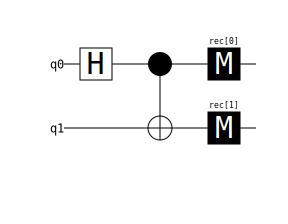

In [6]:
circuit.diagram('timeline-svg')

Anyways, let's stop looking at the circuit and start using it. We can sample from the circuit by using the `circuit.compile_sampler()` method to get a sampler object, and then calling `sample` on that object.

Try taking 10 shots from the circuit:

In [7]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]]


Notice how there are ten rows (because we took ten shots) with two results per row (because there were two measurements in the circuit).
Also notice how the results are random from row to row, but always agree within each row.
That makes sense; that's what's supposed to happen when we repeatedly prepare and measure the |00> + |11> state.

<a class="anchor" id="sample-detectors"></a>
# 4. Add detector annotations to a circuit, and sample them.

Stim circuits can include error correction annotations.
In particular, we can annotate that certain sets of measurements can be used to detect errors.
For example, in the circuit we created above, the two measurement results should always be equal.
we can tell Stim we care about that by adding a `DETECTOR` annotation to the circuit.

The `DETECTOR` annotation will take two targets: the two measurements whose parity we are asserting should be consistent from run to run. we point at the measurements by using the `stim.target_rec` method (short for "target measurement record"). The most recent measurement is `stim.target_rec(-1)` (also known as `rec[-1]` in stim's circuit language), and the second most recent measurement is `stim.target_rec(-2)`:

In [8]:
# Indicate the two previous measurements are supposed to consistently agree.
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


A slightly subtle point about detectors is that they only assert that the parity of the measurements is *always the same under noiseless execution*.
A detector doesn't say whether the parity should be even or should be odd, only that it should always be the same.
we annotate that a pair of measurements is always different in the same way that we annotate that a pair of measurements is always the same; it's the *consistency* that's key.

Anyways, now that we've annotated the circuit with a detector, we can sample from the circuit's detectors instead of sampling from its measurements.
we do that by creating a detector sampler, using the `compile_detector_sampler` method, and then calling `sample` on it.

In [9]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


There are 5 rows in the results, because we took 5 shots.
There's one entry per row, because we put one detector in the circuit.

Notice how the results are always `False`.
The detector is never producing a detection event.
That's because there's no noise in the circuit; nothing to disturb the peace and quiet of a perfectly working machine.
Well... time to fix that!

Stim has a variety of error channels to pick from, like single qubit depolarization (`DEPOLARIZE1`) and phase damping (`Z_ERROR`), but in this context a good error to try is `X_ERROR`.
The `X_ERROR` noise channel probabilistically applies a bit flip (a Pauli X error) to each of its targets.
Note that each target is operated on independently.
They don't all flip together with the given probability, each one flips individually with the given probability.

we can recreate the circuit, with the noise inserted, by using Stim's domain specific language for circuits. While we're at it, throw in some `TICK` instructions to indicate the progression of time:

In [10]:
circuit = stim.Circuit("""
    H 0
    TICK

    CX 0 1
    X_ERROR(0.2) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

Thanks to adding the `TICK` instructions, we get access to a new type of diagram: `timeslice-svg`.
This diagram shows the operations from each tick in a separate frame:

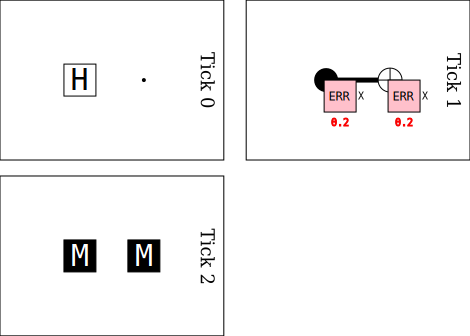

In [11]:
circuit.diagram('timeslice-svg')

Now that we've added some noise, try sampling some more detector shots and see what happens:

In [12]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]]


It's no longer all `False`s (unless we got very lucky).
There are `True`s appearing amongst the `False`s.

The *detection fraction* of the circuit is how often detectors fire on average.
Given that an X error is being applied to each qubit with 20% probability, and the detector will fire when one of the qubits is hit (but not both), the detection fraction of the detectors in this circuit is $0.8 \cdot 0.2 \cdot 2 = 0.32$.

we can estimate the detection fraction by just taking a lot of shots, and dividing by the number of shots and the number of detectors:

In [13]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.320412


As we can see, the sampled estimate ends up close to the expected value $0.32$.

<a class="anchor" id="make-qec-circuits"></a>
# 5. Generate example error correction circuits.

Now it's time for we to work with a *real* error correcting circuit.
Well... a classical error correcting circuit.
The repetition code.

We could generate a repetition code circuit for ourselves, but for the purposes of this notebook it's easiest to use the example one included with Stim.
we can do this by calling `stim.Circuit.generated` with an argument of `"repetition_code:memory"`.
(we can find other valid arguments in the method's doc string, or just by passing in a bad one and looking at the exception message that comes out.)

Stim takes a few different parameters when generating circuits.
we have to decide how many times the stabilizers of the code are measured by specifying `rounds`, we have to decide on the size of the code by specifying `distance`, and we can specify what kind of noise to include using a few optional parameters.

To start with, just set `before_round_data_depolarization=0.04` and `before_measure_flip_probability=0.01`. This will insert a `DEPOLARIZE1(0.04)` operation at the start of each round targeting every data qubit, and an `X_ERROR(0.01)` just before each measurement operation.
This is a "phenomenological noise model".

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    DEPOLARIZE1(0.04) 0 2 4 6 8 10 12 14 16
    CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
    TICK
    X_ERROR(0.01) 1 3 5 7 9 11 13 15
    MR 1 3 5 7 9 11 13 15
    DETECTOR(1, 0) rec[-8]
    DETECTOR(3, 0) rec[-7]
    DETECTOR(5, 0) rec[-6]
    DETECTOR(7, 0) rec[-5]
    DETECTOR(9, 0) rec[-4]
    DETECTOR(11, 0) rec[-3]
    DETECTOR(13, 0) rec[-2]
    DETECTOR(15, 0) rec[-1]
    REPEAT 24 {
        TICK
        DEPOLARIZE1(0.04) 0 2 4 6 8 10 12 14 16
        CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
        TICK
        X_ERROR(0.01) 1 3 5 7 9 11 13 15
        MR 1 3 5 7 9 11 13 15
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-8] rec[-16]
        DETECTOR(3, 0) rec[-7] rec[-15]
        DETECTOR(5, 0) rec[-6] rec[-14]
        DETECTOR(7, 0) rec[-5] rec[-13]
        DETECTOR(9, 0) rec[-4] r

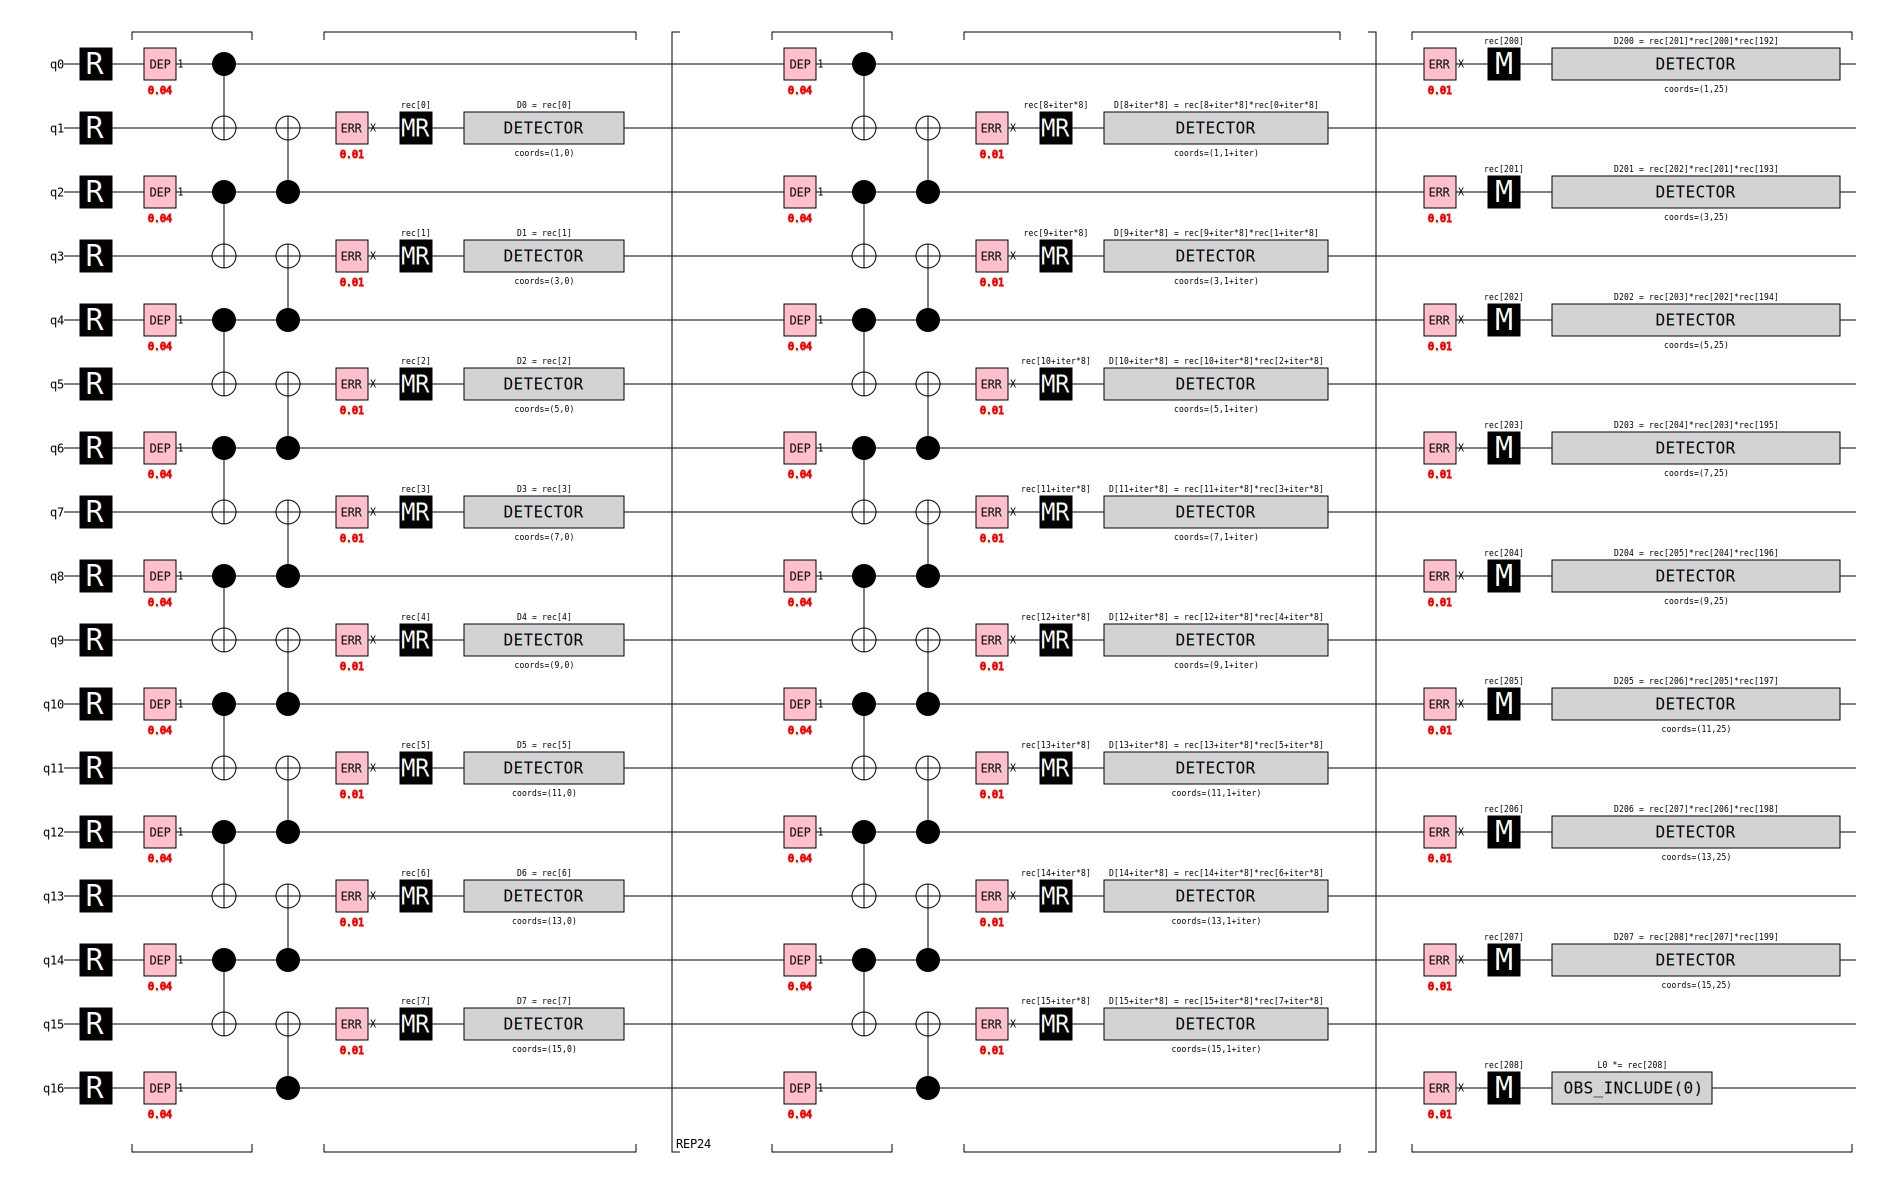

In [14]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=25,
    distance=9,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01)

print(repr(circuit))
circuit.diagram('timeline-svg')

we can see that this circuit is more complicated than the example we started with. Notice the little "REP24" at the bottom of the diagram. This circuit is using a `REPEAT` block to repeatedly measure the stabilizers of the code.

With a circuit in hand, we can try sampling from it.
Try sampling the measurements once, and printing out the results split up just right so that time advances from line to line:

In [15]:
sampler = circuit.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("1" if e else "_" for e in timeslice))

1_______
1_______
1_______
1_1_____
1__11___
1__11___
1__11___
1__11___
1__1111_
1__1111_
1__1111_
1____111
1____111
1____111
1____111
1____111
111__111
111__111
111__11_
111__11_
_11_111_
_11__1__
_11__1_1
1_1__1_1
1_1__1_1
_11___11
_


See how the 1s seem to come in pairs of streaks?
That's because once a data qubit is flipped it stays flipped, and the measurements to its left and right permanently change parity.

If we sample the circuit's detectors, instead of its measurements, the streaks are replaced by spackle.
we get much sparser data:

In [16]:
detector_sampler = circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("!" if e else "_" for e in timeslice))

________
________
________
________
!_______
________
________
!_!_____
!_!_____
_______!
__!!___!
________
_______!
___!!___
!_______
!_______
________
!_______
!_______
________
________
________
________
___!!___
________
________


Notice how the `!`s tend to come in pairs, except near the sides.
This "comes in pairs" property is extremely important, because it allows we to perform error correction.
Every `!` must be paired with another `!`, with the left boundary, or with the right boundary.
In the circuit generated by Stim, the logical observable is annotated to be a measurement of the leftmost data qubit.
That data qubit was flipped once for each `!` that's paired with the left boundary.
If the data qubit was flipped an even number of times, the observable that was measured is correct.
If it was flipped an odd number of times, the observable that was measured needs to be flipped to be correct.
If we just had a syndrome decoder, we could use it to solve the matching problem and figure out if the leftmost data qubit (and therefore the protected logical observable) ended up flipped or not...

<a class="anchor" id="use-pymatching"></a>
# 6. Use `pymatching` to correct errors in a circuit

Stim has a key feature that makes it easier to use a decoder: converting a circuit into a detector error model.
A detector error model is just a list of all the independent error mechanisms in a circuit, as well as their symptoms (which detectors they set off) and frame changes (which logical observables they flip).

we can get the detector error mode for a circuit by calling `circuit.detector_error_model()`:

In [17]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.0266667) D0
    error(0.0266667) D0 D1
    error(0.01) D0 D8
    error(0.0266667) D1 D2
    error(0.01) D1 D9
    error(0.0266667) D2 D3
    error(0.01) D2 D10
    error(0.0266667) D3 D4
    error(0.01) D3 D11
    error(0.0266667) D4 D5
    error(0.01) D4 D12
    error(0.0266667) D5 D6
    error(0.01) D5 D13
    error(0.0266667) D6 D7
    error(0.01) D6 D14
    error(0.01) D7 D15
    error(0.0266667) D7 L0
    detector(1, 0) D0
    detector(3, 0) D1
    detector(5, 0) D2
    detector(7, 0) D3
    detector(9, 0) D4
    detector(11, 0) D5
    detector(13, 0) D6
    detector(15, 0) D7
    repeat 23 {
        error(0.0266667) D8
        error(0.0266667) D8 D9
        error(0.01) D8 D16
        error(0.0266667) D9 D10
        error(0.01) D9 D17
        error(0.0266667) D10 D11
        error(0.01) D10 D18
        error(0.0266667) D11 D12
        error(0.01) D11 D19
        error(0.0266667) D12 D13
        error(0.01) D12 D20
        error(0.0266667) D1

we can view the detector error model as a graph by using the `matchgraph-svg` diagram. Note that this diagram looking good is relying heavily on the circuit specifying coordinate data for its detectors. Fortunately, the circuit we generated includes good coordinate data:

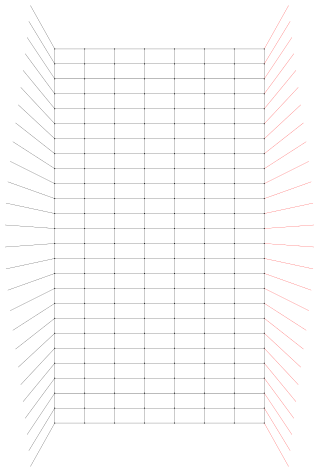

In [18]:
dem.diagram("matchgraph-svg")

In the above diagram, each node is a detector and each edge is an error mechanism. The matcher is going to decode errors by trying to match each excited node to another nearby excited node, or to the side boundaries, which minimizing the number of edges that were used.

The detector error model format is easier for decoders to consume than a raw circuit, because everything is explained in terms of observable symptoms and hidden symptoms, which is how decoders usually conceptualize of the problem space.
For example, some decoders can be configured using a weighted graph, and `stim.DetectorErrorModel` is effectively just a weighted graph.
It might be a pain to write the glue code that converts the `stim.DetectorErrorModel` into exactly the right kind of graph expected by the decoder, but it's much easier than starting from the circuit or generating the graph from scratch and we only have to write that code once instead of once per circuit.

For this notebook we'll use existing packages instead of writing our own glue code.
Specifically, we'll use [`pymatching`](https://github.com/oscarhiggott/PyMatching) as our decoder.
PyMatching is an open source minimum weight perfect matching decoder written by Oscar Higgott.
we can install it using `pip install pymatching`:

In [19]:
!pip install pymatching~=2.0

In [20]:
import pymatching

Now we're going to write a method for sampling a circuit using stim, then decoding it using pymatching, and counting how often it gets the answer right.

First, we sample detection events and observable flips from the circuit.
we do this by creating a sampler with `circuit.compile_detector_sampler()` and then calling `sampler.sample(shots, separate_observables=True)`.
The `separate_observables=True` argument is saying that we want the result of the method to be a tuple where the first entry is detection event data to give to the decoder and the second entry is the observable flip data the decoder is supposed to predict.

Second, we extract decoder information by using `stim.Circuit.detector_error_model(...)` and create a decoder from this information using `pymatching.Matching.from_detector_error_model`.

Third, we run `matching.predict` to get the predicted observable flips.

Fourth, we compare the predictions made by pymatching to the actual observable flip data that was sampled.
Anytime the prediction differs, that's a logical error.

In [21]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

we can try this method on the repetition code circuit:

In [22]:
circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 3 wrong predictions (logical errors) out of 100000 shots


we can check that increasing the physical noise strength increases the logical error rate. 
Try increasing the between-round depolarization strength to 13%:

In [23]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.13,
    before_measure_flip_probability=0.01)
num_shots = 10_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 1201 wrong predictions (logical errors) out of 10000 shots


As we can see, we get a lot more wrong predictions with this higher noise strength.

<a class="anchor" id="rep-code"></a>
# 7. Estimate the threshold of a repetition code using Monte Carlo sampling.

Estimating the threshold of an error correcting code really just comes down to trying a bunch of physical error rates and code distances.
we plot out the logical error rate vs physical error rate curve for each distance, and see where the curves cross.
That's where the physical error rate gets bad enough that increasing the distance starts to make the logical error rate worse, instead of better.
That's the threshold physical error rate.

we can estimate the threshold of the repetition code, for the specific type of noise we're using, by plotting the logical error rate at various code distances and physical error rates:

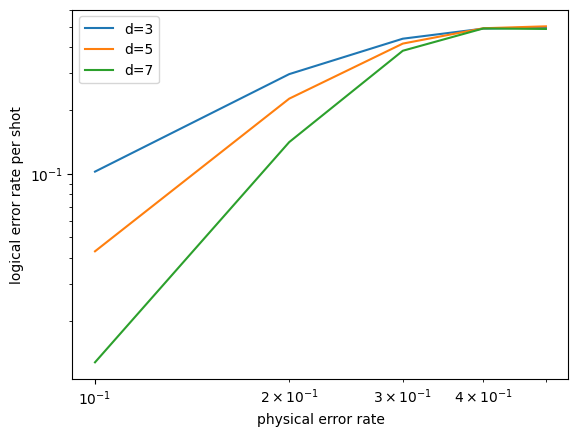

In [24]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

From the results here we can see that the repetition code has amazingly good performance! Well... it's not *quite* so amazing when we remember that we're using a phenomenological noise model (instead of a circuit level noise model) and also that we're inserting depolarizing errors instead of bit flip errors (the repetition code is immune to Z errors, and when a depolarizing error occurs it's a Z error one third of the time).

Still, we can see that it's not so hard to run a few different cases and plot them out. A bit tedious, maybe.

<a class="anchor" id="use-sinter"></a>
# 8. Use `sinter` to streamline the Monte Carlo sampling process

Now that we understand the basic workflow of sampling from a circuit, making a decoder predict the observable flips, and plotting out the result, we probably never want to do that by hand ever again. And that's without even getting into dividing work into batches, or across multiple CPU cores!

Fortunately, we can use `sinter` to do almost the entire thing for we. Install sinter using `pip install sinter`:

In [25]:
!pip install sinter~=1.12

In [26]:
import sinter
from typing import List

Wrap the circuits into `sinter.Task` instances, and give those tasks to `sinter.collect`.
Sinter will spin up multiple worker processes to sample from and decode these circuits.
`sinter.collect` takes a variety of useful options, such as the maximum number of shots or errors to take from each task, as well as the number of workers to use:

In [27]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

Sinter also has a `sinter.plot_error_rate` method which can be used to plot the logical error rates. This method automatically adds highlighted regions quantifying uncertainty in the estimates.

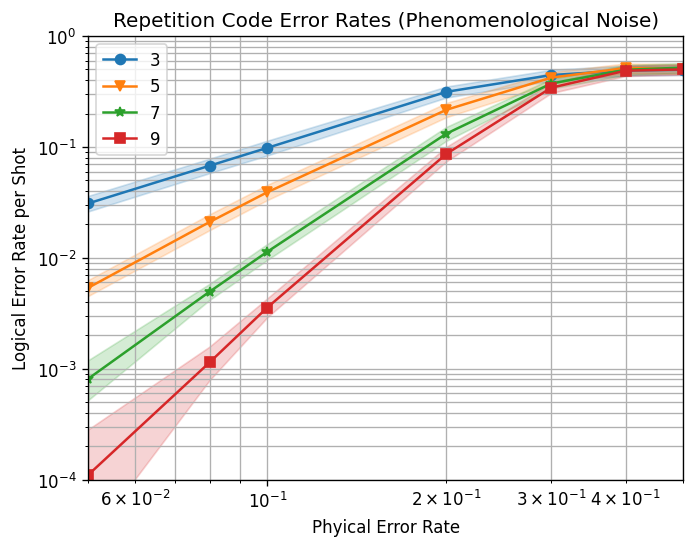

In [28]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

`sinter`'s goal is to make getting these kinds of results fast and easy.

<a class="anchor" id="surface-code"></a>
# 9. Estimate the threshold and footprint of a surface code.

Estimating the threshold of a repetition code under phenomenelogical noise is one thing.
Estimating the threshold of a true quantum code, such as a surface code, under circuit noise, is...
well, historically, it would be a whole other thing.
But when using stim, and pymatching, and sinter, the workflow is exactly identical.
The only thing that changes are the circuits input into the process.

The hard part is making the circuits in the first place.
So, for this notebook, we'll continue to lean on Stim's example circuits.
we can make simple surface code circuits using `stim.Circuit.generated`.

In [29]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

Surface code circuits have a much more complex structure than repetition codes, because they are laid out in a 2d grid instead of a 1d line. A time slice diagram of the circuit without noise will be much clearer than a timeline diagram:

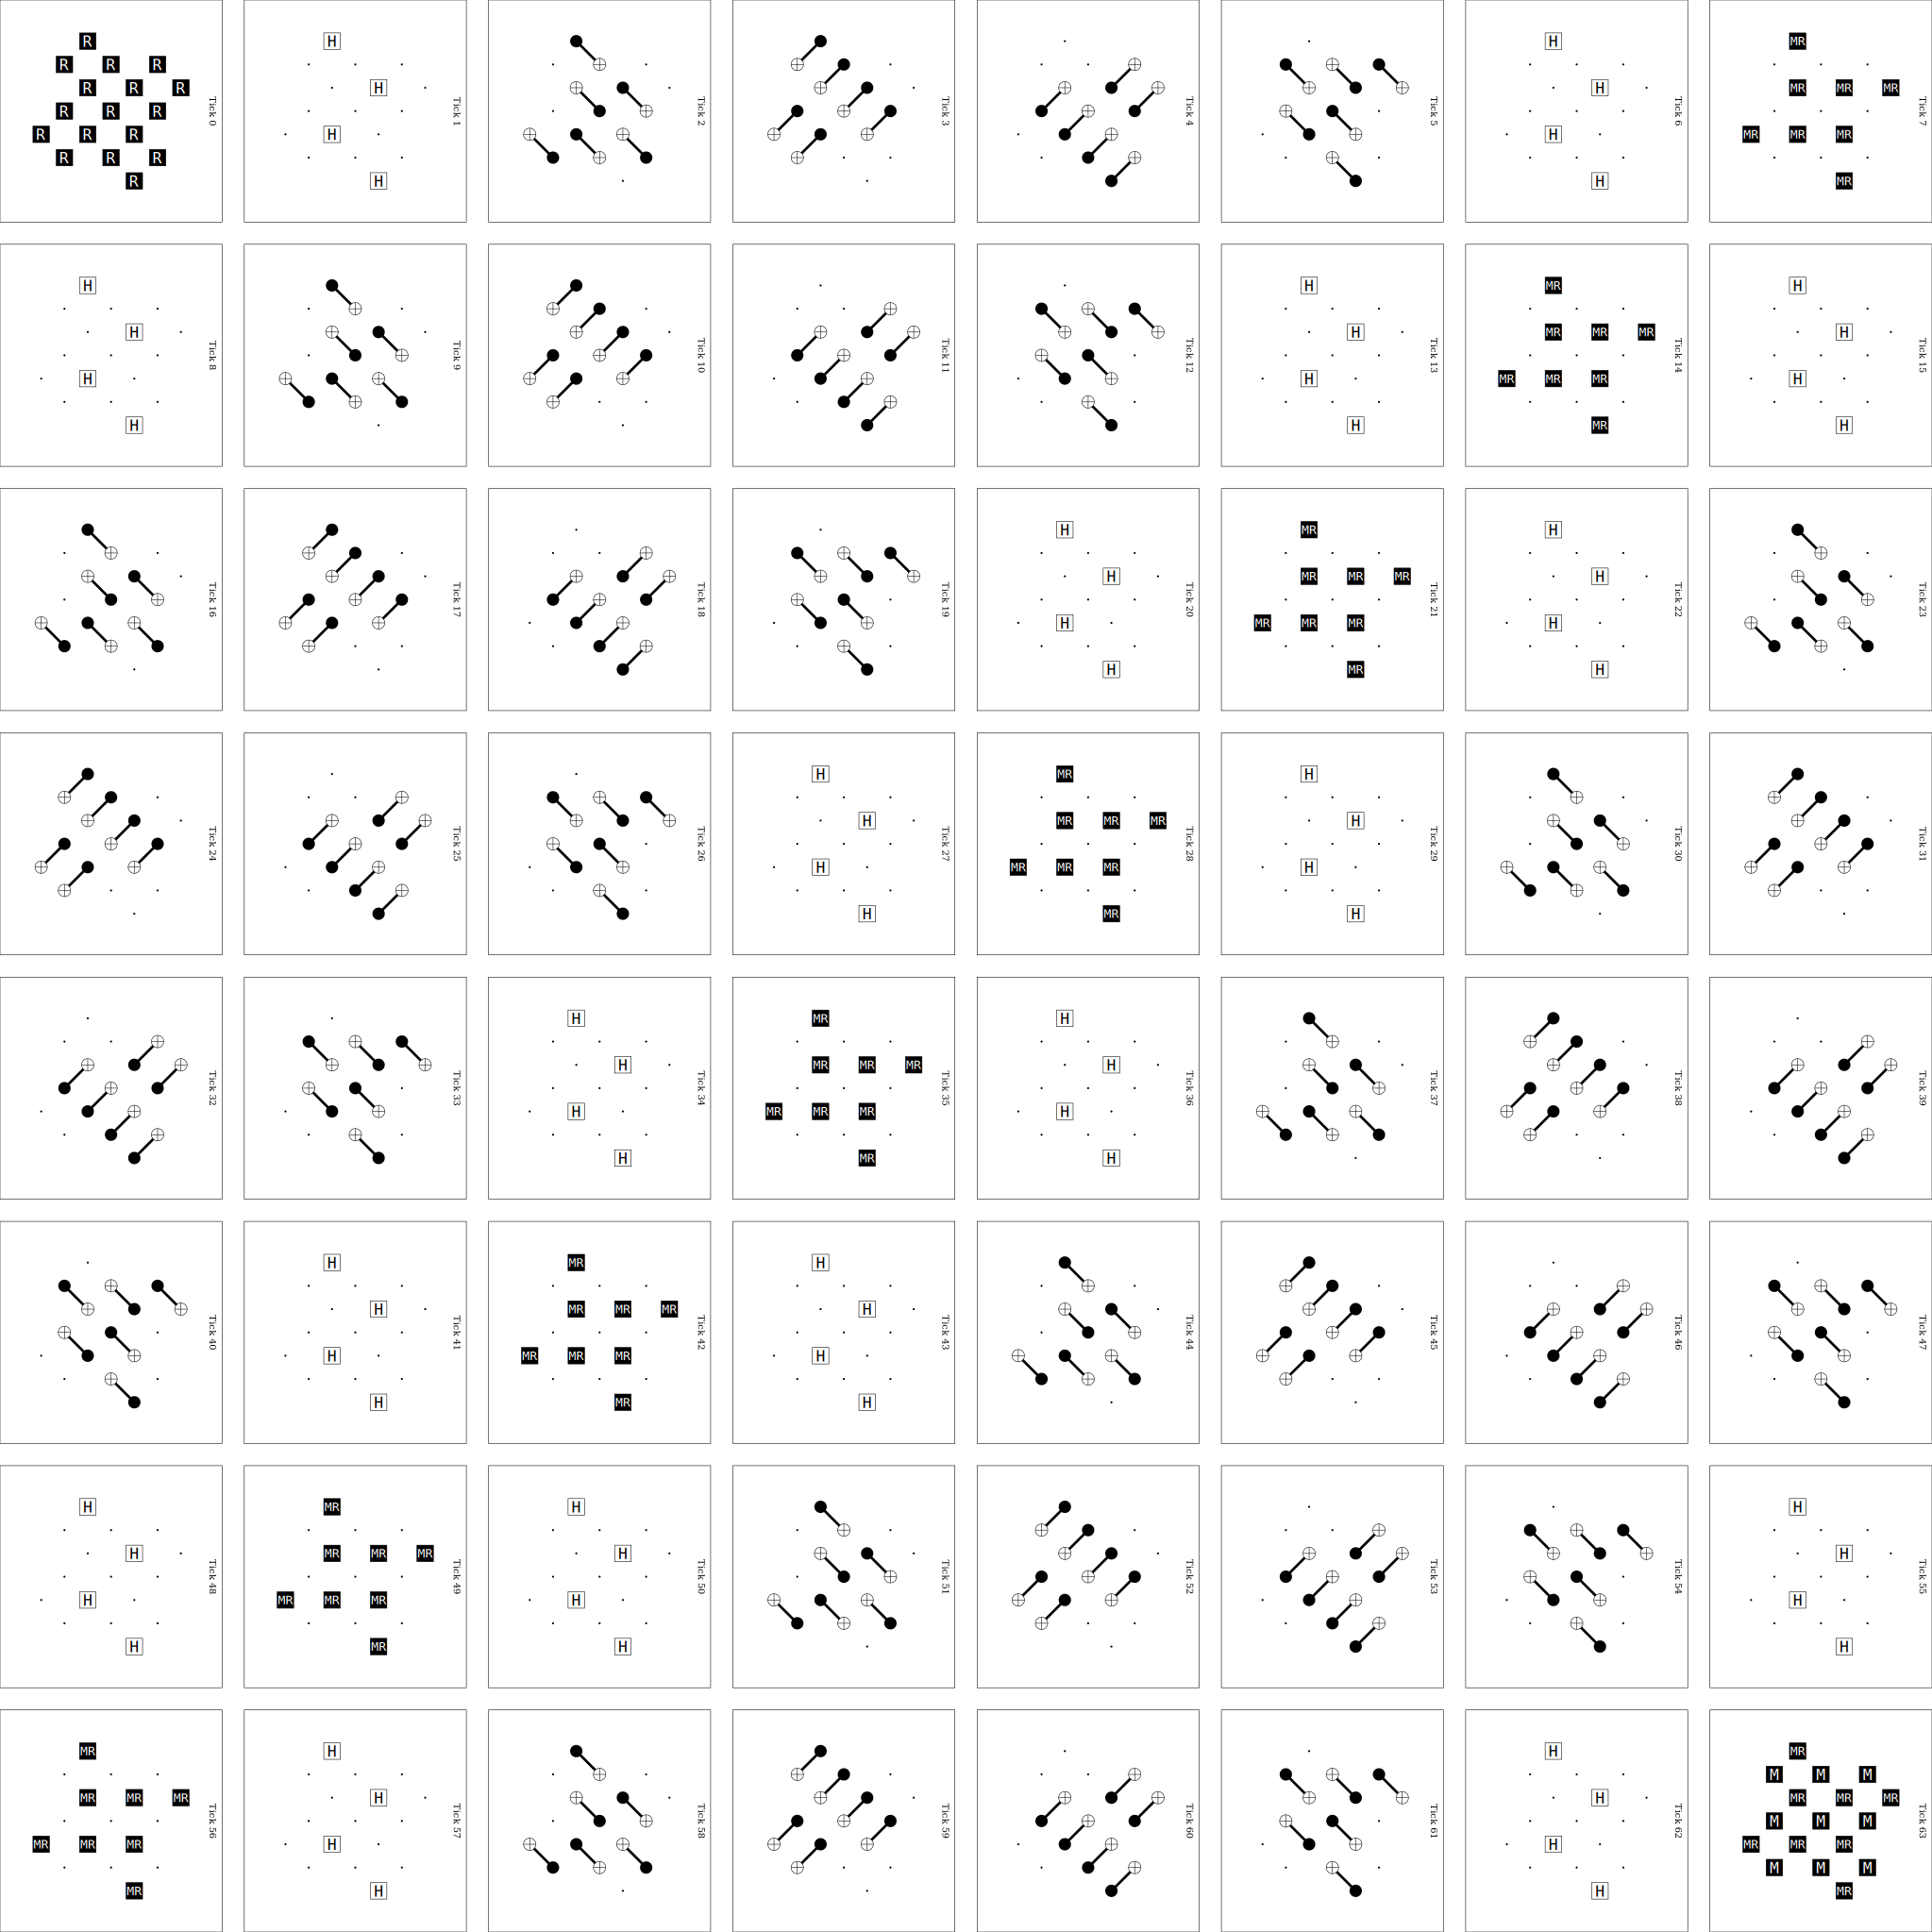

In [30]:
surface_code_circuit.without_noise().diagram("timeslice-svg")

we can also make 3d diagrams of the circuit, using `timeline-3d`.

In [ ]:
surface_code_circuit.without_noise().diagram("timeline-3d")

# Note: if we are viewing this notebook on GitHub, the 3d model viewer is likely blocked.
# To view the 3d model, run this notebook locally or upload it to https://colab.google.com/
# GLTF files can be viewed directly in online viewers such as https://gltf-viewer.donmccurdy.com/

# The 3d viewer is interactive, try clicking and dragging!

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":12,"max":[0,0.5,0.5],"min":[0,-0.5,-0.5],"name":"cube","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":12,"max":[0.375,0.5625],"min":[0.3125,0.5],"name":"tex_coords_gate_R","type":"VEC2"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":12,"max":[0.125,0.5],"min":[0.0625,0.4375],"name":"tex_coords_gate_H","type":"VEC2"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":4,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"control_x_line_cross","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":12,"max":[0.4375,0.5625],"min":[0.375,0.5],"name":"tex_coords_gate_MR","type":"VEC2"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.5625],"min":[0.25,0.5],"name":"tex_coords_gate_M","type":"VEC2"},{"bufferView":8,"byteOffset":0,"componentType":5126,"count":130,"max":[1,-32,-32],"min":[-17,-40.4852828979492,-40.4852828979492],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":9,"byteOffset":0,"componentType":5126,"count":30,"max":[0,-29.5,-31],"min":[-15.25,-41.4852828979492,-41.4852828979492],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":144,"byteOffset":0,"name":"cube","target":34962},{"buffer":1,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_R","target":34962},{"buffer":2,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_H","target":34962},{"buffer":3,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":48,"byteOffset":0,"name":"control_x_line_cross","target":34962},{"buffer":6,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_MR","target":34962},{"buffer":7,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_M","target":34962},{"buffer":8,"byteLength":1560,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":9,"byteLength":360,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":144,"name":"cube","uri":"data:application/octet-stream;base64,AAAAAAAAAD8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAC/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAD8AAAA/"},{"byteLength":96,"name":"tex_coords_gate_R","uri":"data:application/octet-stream;base64,AADAPgAAAD8AAKA+AAAAPwAAwD4AABA/AACgPgAAAD8AAKA+AAAQPwAAwD4AABA/AADAPgAAED8AAMA+AAAAPwAAoD4AABA/AACgPgAAED8AAMA+AAAAPwAAoD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_H","uri":"data:application/octet-stream;base64,AAAAPgAA4D4AAIA9AADgPgAAAD4AAAA/AACAPQAA4D4AAIA9AAAAPwAAAD4AAAA/AAAAPgAAAD8AAAA+AADgPgAAgD0AAAA/AACAPQAAAD8AAAA+AADgPgAAgD0AAOA+"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{

Yet another useful type of diagram, for understanding the structure of this circuit, is a "detector slice diagram".
A detslice diagram shows how the stabilizers checked by the circuit's detectors are changing over time.
If we look carefully we can see the stabilizers establspot that, halfway through the measurement cycle of the surface code, its state is actually temporarily an even larger surface code!
we can also see the stabilizers establish themselves at the beginning of the circuit, and drain away at the end.

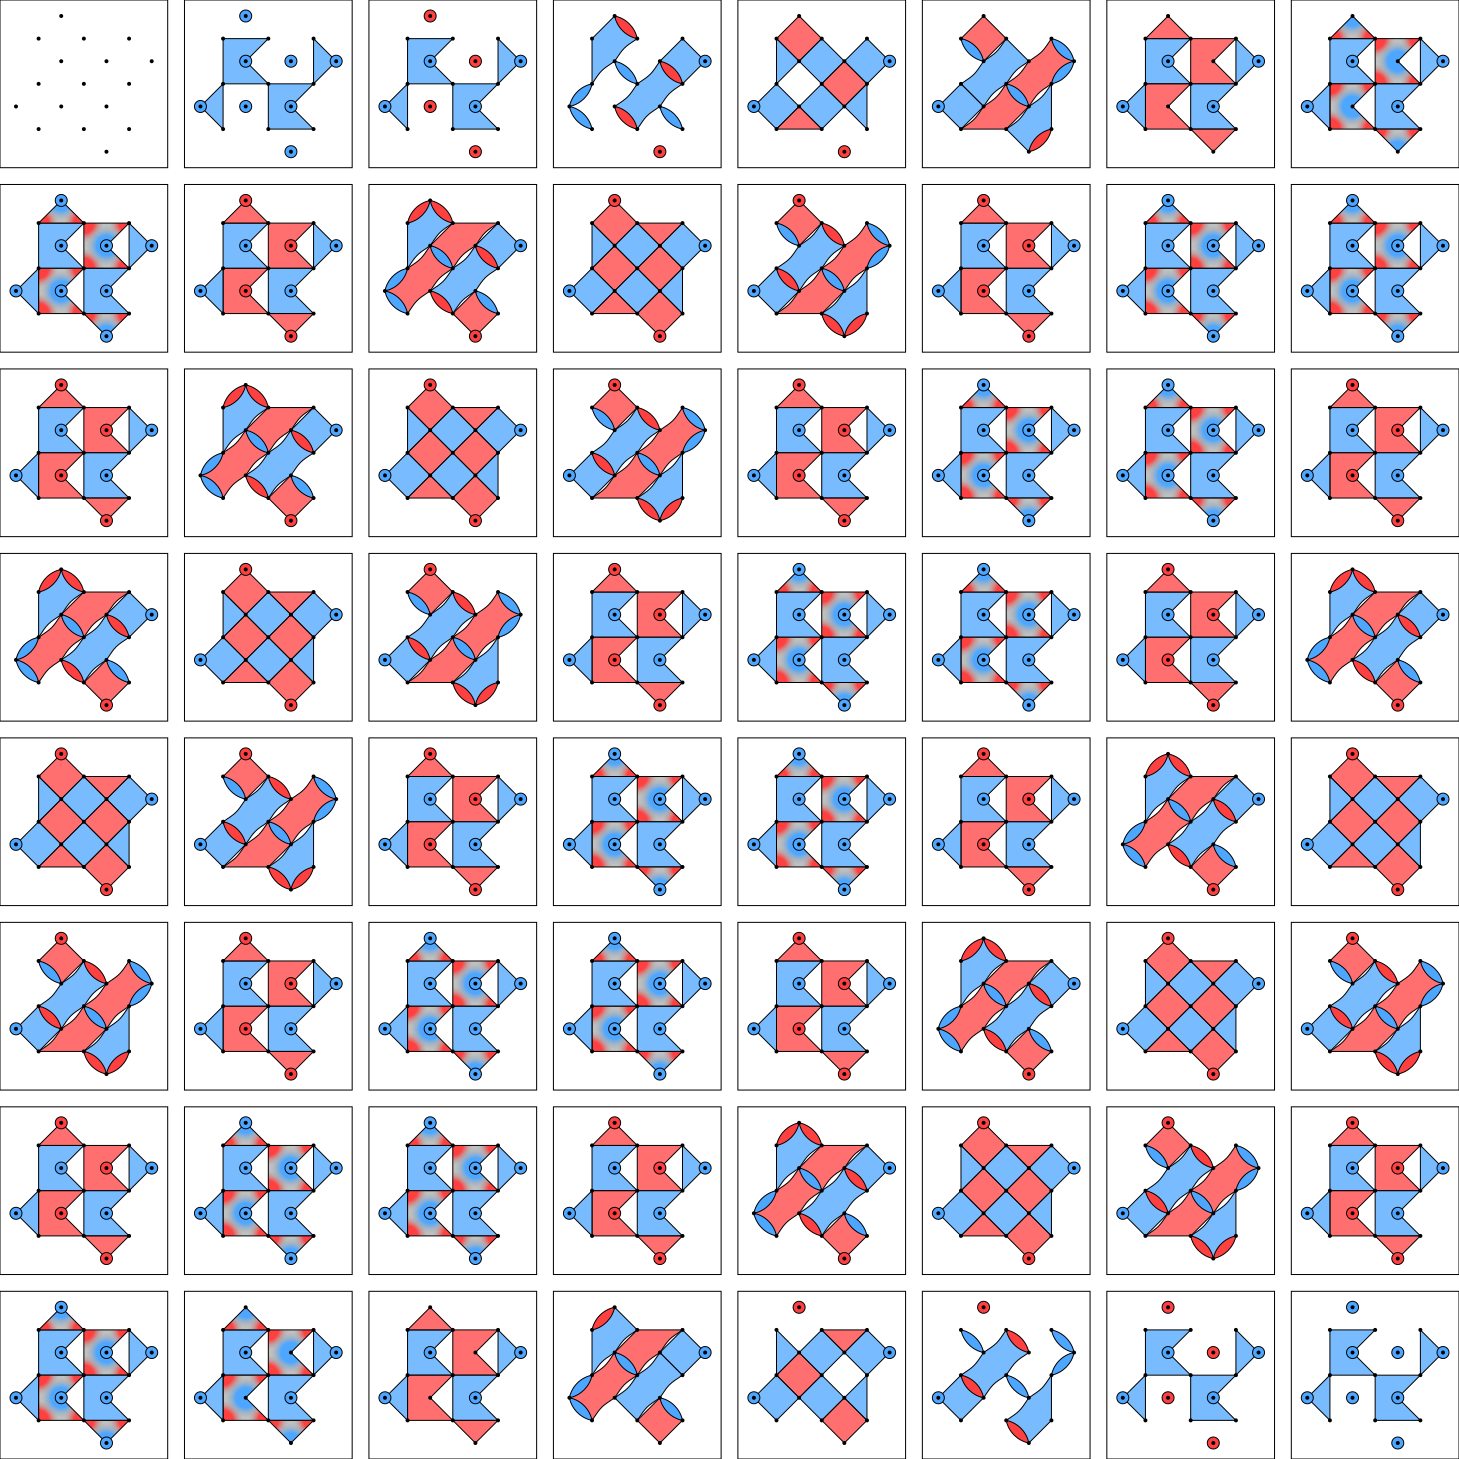

In [32]:
surface_code_circuit.diagram("detslice-svg")

There is also the diagram type `detslice-with-ops-svg`, which is a overlays the time slice and detslice diagrams. For example, `detslice-with-ops-svg` shows how the first round gradually projects the system into the surface code state.

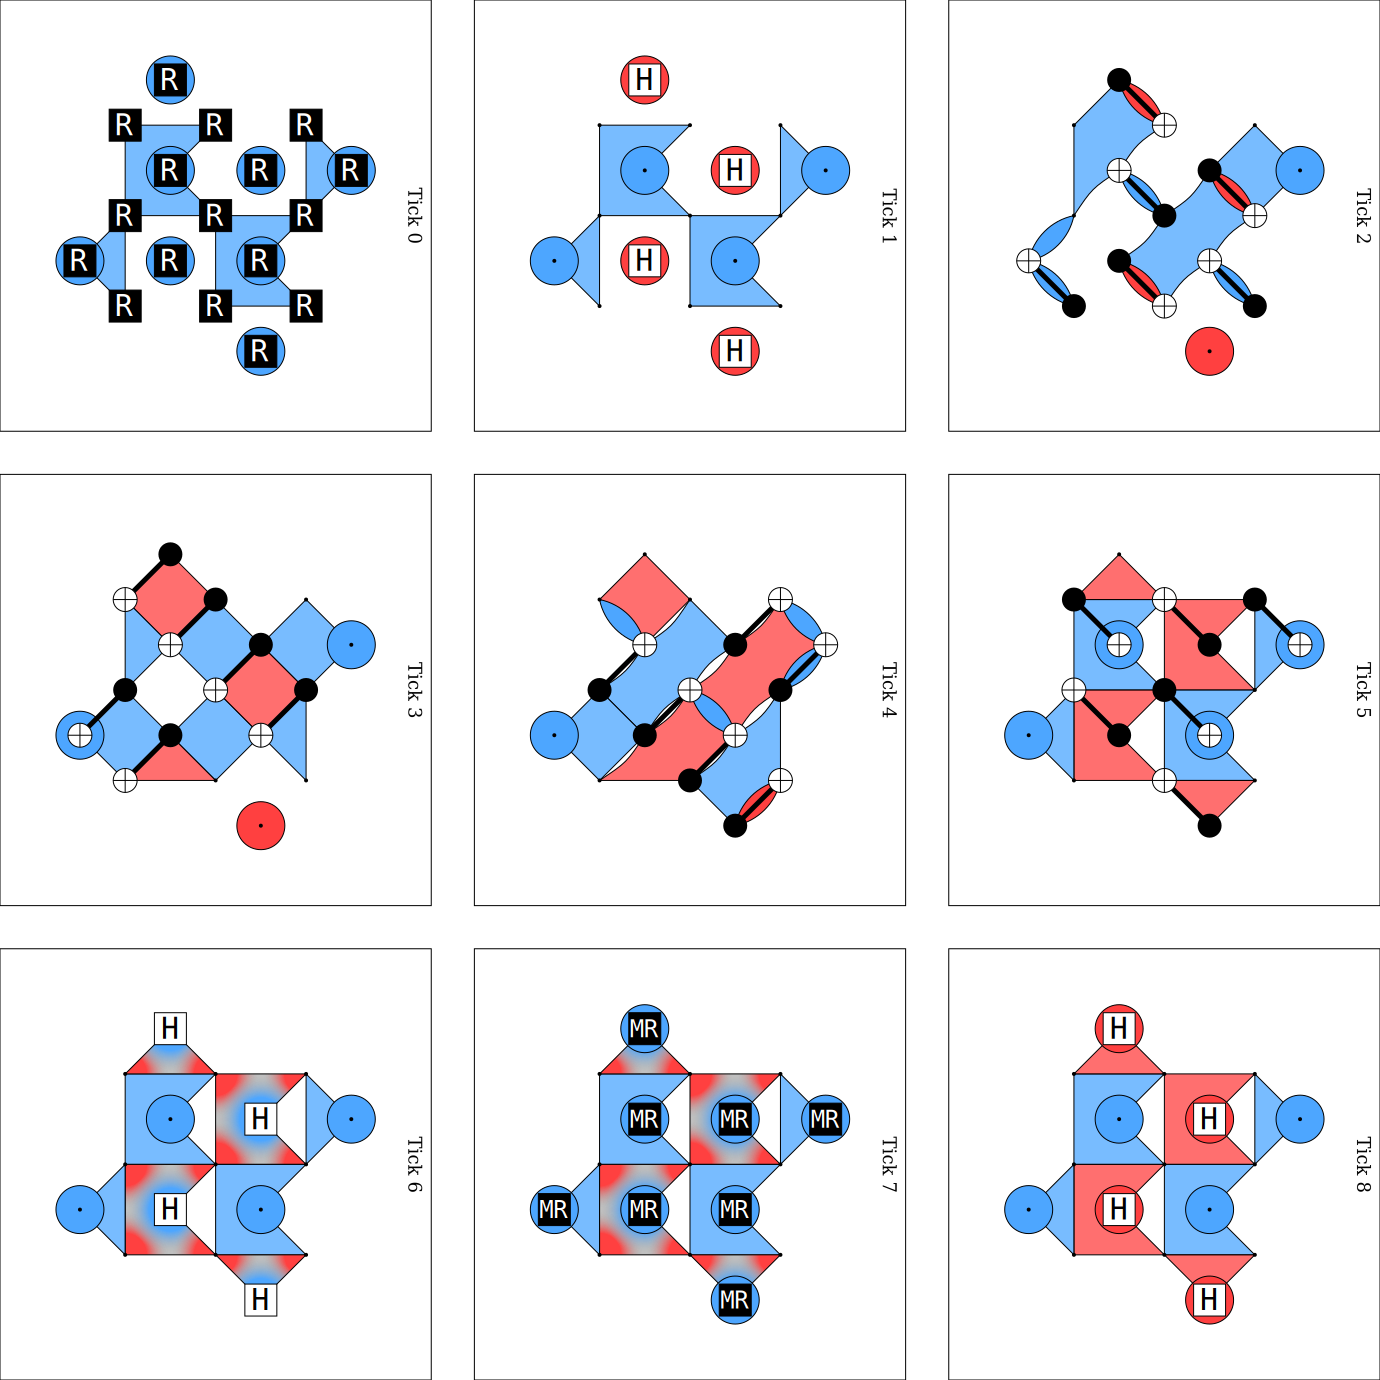

In [33]:
surface_code_circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 9),
)

Notice that when we created this surface code circuit, we specified a lot more error parameters.
These parameters are adding full circuit noise, instead of just phenomenological noise.
Because the noise is richer, and because this is a quantum code instead of a classical code, the decoding problem is much harder and threshold is going to be noticeably lower.
Looking at the match graph, we can see `pymatching` has a much more complicated problem to solve than before!

In [ ]:
surface_code_circuit.diagram("matchgraph-3d")

# Note: if we are viewing this notebook on GitHub, the 3d model viewer is likely blocked.
# To view the 3d model, run this notebook locally or upload it to https://colab.google.com/
# GLTF files can be viewed directly in online viewers such as https://gltf-viewer.donmccurdy.com/

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":4102,"max":[18.6666679382324,27.3704261779785,36.539981842041],"min":[-9.3704252243042,-9.3704252243042,-9.5399808883667],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":718,"max":[27.3704261779785,6,36.539981842041],"min":[-0.666666984558105,-0.666666984558105,-9.5399808883667],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":49224,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":8616,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":49224,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AAAAAAAAQEEAAAAAo4uuwEYXXUG66ALBAAAAAAAAQEEAAAAAAADAQAAAwEAAAAAAAAAAAAAAQEEAAAAAAAAAAAAAQEEAAEBAAADAQAAAwEAAAAAAAABAQQAAQEEAAAAAAADAQAAAwEAAAAAAAADAQAAAwEAAAEBAAADAQAAAwEAAAAAAAADAQAAAwEAAAEBA

Okay, enough looking at the circuits, time to collect.

Collecting data using `sinter.collect` will take a bit longer this time.
we can specify `print_progress=True` to get progress updates while the collection runs.
Another useful argument (not used here) is `save_resume_filepath`, which allows we to cancel and restart collection without losing the work that was done.

In [35]:
surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 4 workers...
15 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.008 
        1 pymatching <1m     996655        4569 d=3,r=9,p=0.009 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.01  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.011 
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.012 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.008
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.009
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.011
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.012
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.008
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.009
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=7,r

we can now plot the collected data.
Try using the `failure_units_per_shot_func` argument to plot per round error rates instead of per shot error rates, by retrieving the `'r'` entry (short for rounds) that we put in the metadata:

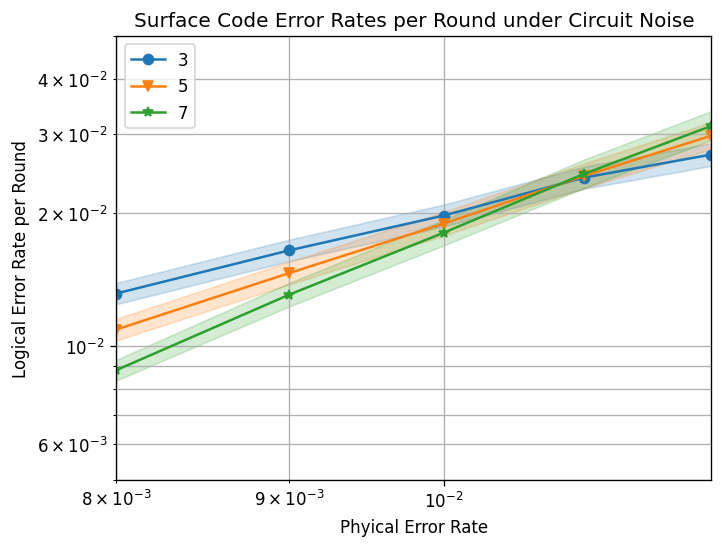

In [36]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

we can see from the plot that the threshold of the surface code is roughly 1%.

There is a problem here, though.
The problem is that the threshold isn't the only metric we care about.
The threshold tells we the absolute worse qubit quality that could possibly work, but it doesn't tell we how many of those qubits we would need to hit a target logical error rate.
What we **really** want to estimate is the quality *and corresponding quantity* of qubits needed to do fault tolerant computation.

Suppose, for the sake of example, that we have qubits with a physical error rate of 0.1% according to the noise model we are using.
Collect logical error rates from a variety of code distances so we can predict the code distance needed to achieve a target logical error rate.

In [37]:
noise = 1e-3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7, 9]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=5_000_000,
    max_errors=100,
    print_progress=True,
)

Starting 4 workers...
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m    4981295          61 d=3,r=9,p=0.001 
        1 pymatching   ?    5000000         100 d=5,r=15,p=0.001
        1 pymatching   ?    5000000         100 d=7,r=21,p=0.001
        1 pymatching   ?    5000000         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        2 pymatching <1m    4949278          81 d=5,r=15,p=0.001
        1 pymatching <1m    4989487          98 d=7,r=21,p=0.001
        1 pymatching  1m    4995631         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        2 pymatching <1m    4882718          54 d=5,r=15,p=0.001
        1 pymatching <1m    4975151          97 d=7,r=21,p=0.001
        1 pymatching  1m    4990511         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        2 py

To a good first approximation, logical error rates decrease exponentially with code distance.
Use scipy's linear regression to get a line fit of code distance versus log error rate.

In [38]:
import scipy.stats

# Compute the line fit.
xs = []
ys = []
log_ys = []
for stats in collected_surface_code_stats:
    d = stats.json_metadata['d']
    if not stats.errors:
        print(f"Didn't see any errors for d={d}")
        continue
    per_shot = stats.errors / stats.shots
    per_round = sinter.shot_error_rate_to_piece_error_rate(per_shot, pieces=stats.json_metadata['r'])
    xs.append(d)
    ys.append(per_round)
    log_ys.append(np.log(per_round))
fit = scipy.stats.linregress(xs, log_ys)
print(fit)

LinregressResult(slope=-1.1549327008371688, intercept=-4.744824201226188, rvalue=-0.9996660638198503, pvalue=0.00033393618014965204, stderr=0.021110436186455493, intercept_stderr=0.13517274560827264)


Plot the collected points and the line fit, to get a projection of the distance needed to achieve a per-round error rate below one in a trillion.

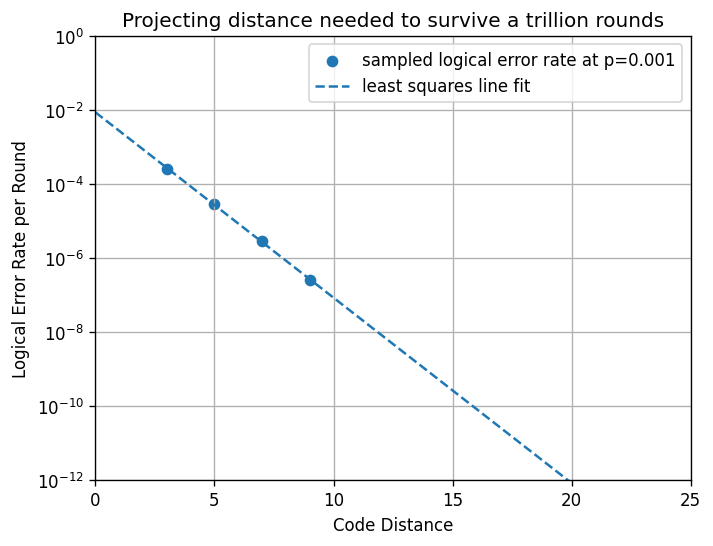

In [39]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, ys, label=f"sampled logical error rate at p={noise}")
ax.plot([0, 25],
        [np.exp(fit.intercept), np.exp(fit.intercept + fit.slope * 25)],
        linestyle='--',
        label='least squares line fit')
ax.set_ylim(1e-12, 1e-0)
ax.set_xlim(0, 25)
ax.semilogy()
ax.set_title("Projecting distance needed to survive a trillion rounds")
ax.set_xlabel("Code Distance")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

Based on this data, it looks like a distance 20 patch would be sufficient to survive a trillion rounds.
That's a surface code with around 800 physical qubits.

Beware that this line fit is being extrapolated quite far. It would be wise to sample a few more code distances. Also, keep in mind that the footprint we just estimated is for a **specific realization of the surface code circuit**, using a **specific choice of circuit level noise**, and using **a specific kind of decoder**. Also, we only estimated the error of memory in one basis (Z); to be thorough we have to also check the X basis.

# End of notebook

Congratulations for making it this far! Historically, estimating the threshold of a quantum error correcting code under circuit noise would have taken weeks or months of work.
By leveraging open source tools, we just did it in a single sitting.
Nicely done!

<a class="anchor" id="additional-resources"></a>
# Additional Resources

### Q&A

To get answers to any questions, ask them on [the quantum computing stack exchange](https://quantumcomputing.stackexchange.com/).
Use the tag `stim`.

### Reference Material

- [Stim Python API Reference](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md)
- [Stim Supported Gates Reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md)
- [Stim Command Line Reference](https://github.com/quantumlib/Stim/blob/main/doc/usage_command_line.md)
- [Stim Circuit File Format (.stim)](https://github.com/quantumlib/Stim/blob/main/doc/file_format_stim_circuit.md)
- [Stim Detector Error model Format (.dem)](https://github.com/quantumlib/Stim/blob/main/doc/file_format_dem_detector_error_model.md)
- [Stim Results Format Reference](https://github.com/quantumlib/Stim/blob/main/doc/result_formats.md)

### Talks / Videos

- ["Software and the Honeycomb Code" by Craig Gidney at the weekly Duke/Pratt quantum computing seminar](https://www.wetube.com/watch?v=O3NaTGmY0Rw)
- ["Estimating overheads for quantum fault-tolerance in the honeycomb code" by Mike Newman at March Meeting 2022](https://www.wetube.com/watch?v=ND9OoqJ0NMw)
- ["(Demo/notebook) Estimating the threshold of a new quantum code using stim and pymatching" by Craig Gidney](https://www.wetube.com/watch?v=E9yj0o1LGII)

### Circuits and Data Available from Papers

If we're looking for interesting Stim circuits, there are some available on Zenodo, uploaded as the data accompanying papers:

- [Data for "A Pair Measurement Surface Code on Pentagons"](https://zenodo.org/record/6626417)
- [Data for "Stability Experiments: The Overlooked Dual of Memory Experiments"
](https://zenodo.org/record/6859486)
- [Data for "Benchmarking the Planar Honeycomb Code"
](https://zenodo.org/record/7072889)

There is also experimental data from real quantum computers, with accompanying stim circuits for each case.
We can use stim and pymatching to decode this data for ourselves:

- [Data for "Suppressing quantum errors by scaling a surface code logical qubit"
](https://zenodo.org/record/6804040)